<a href="https://colab.research.google.com/github/robertZZZZZZZZ/pytorch/blob/main/02_Classification_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import sklearn

In [4]:
from sklearn.datasets import make_circles

# Make samples
n_samples = 1000

# Create circles

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42
                    )
X.shape, y.shape

((1000, 2), (1000,))

In [5]:
print(f"first 5 samples:{X[0:5]}")
print(f"first 5 samples:{y[0:5]}")

first 5 samples:[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples:[1 1 1 1 0]


In [6]:
# Make DataFrame with Pandas
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:, 1],
                        "label" : y})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


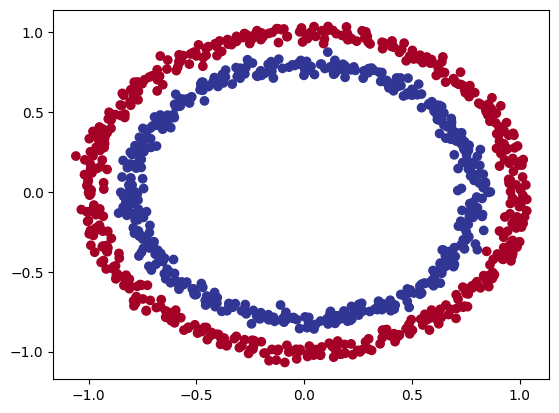

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [8]:
# Turn into Tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
# Split Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

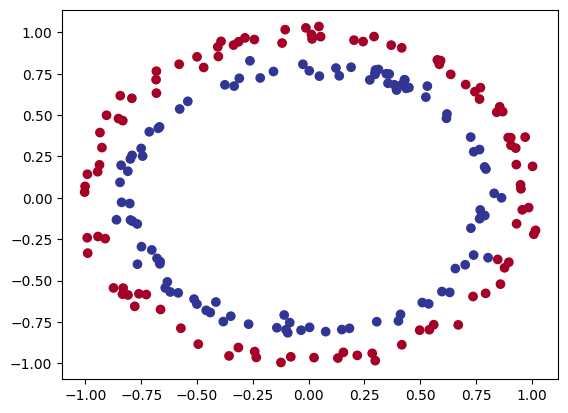

In [11]:
plt.scatter(x=X_test[:,0],
            y=X_test[:,1],
            c=y_test,
            cmap=plt.cm.RdYlBu);

In [12]:
# Building Model
import torch
from torch import nn

In [13]:
from torch._C import device
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
# Create model that subclasses nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)
  
  def forward(self, x):
    y = self.layer_1(x)
    y = self.layer_2(y)
    return y


In [15]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters())

Parameter containing:
tensor([[-0.5756,  0.5839],
        [-0.3912, -0.2137],
        [-0.1215,  0.2149],
        [ 0.0790, -0.1164],
        [ 0.5091, -0.6977]], device='cuda:0', requires_grad=True)

In [17]:
## Replicate model aboce using nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [18]:
# Make predictions
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.7059, -0.0663],
                      [ 0.6218,  0.0099],
                      [ 0.4216, -0.4324],
                      [-0.4059,  0.4824],
                      [-0.0053, -0.1531]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3706, -0.6372,  0.1254,  0.5536, -0.6159], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3124, -0.3225, -0.3979,  0.2242, -0.4275]], device='cuda:0')),
             ('1.bias', tensor([0.1368], device='cuda:0'))])

In [19]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

In [20]:
X_test.shape, untrained_preds.shape

(torch.Size([200, 2]), torch.Size([200, 1]))

In [21]:
untrained_preds[:10]

tensor([[1.2977],
        [1.1338],
        [1.1574],
        [1.3398],
        [0.2528],
        [0.1597],
        [0.4153],
        [0.1849],
        [1.1957],
        [1.1128]], device='cuda:0')

In [61]:
from torch.nn.modules.loss import BCELoss
# Setup loss function and optimizer
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss
loss_fn = BCEWithLogitsLoss()
optimizer = SGD(params=model_0.parameters(),
            lr=0.1)

In [23]:
# Calculate accuracy
def accuracy_fn(y_true, y_preds):
  correct= torch.eq(y_true, y_preds).sum().item()
  acc = (correct/len(y_preds)*100)
  return acc


In [24]:
# Train model

epochs = 200


X_train, y_train =  X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  model_0.train()
  # Forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_preds=y_preds)
  
  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss Backprop
  loss.backward()

  # Backpropagation
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
     test_logits = model_0(X_test).squeeze()
     test_preds = torch.round(torch.sigmoid(test_logits))

     test_loss = loss_fn(test_logits,
                         y_test)
     test_acc = accuracy_fn(y_true=y_test,
                          y_preds=test_preds)
     if epoch % 10 ==0:
       print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.79521, Acc: 50.50% | Test loss: 0.78621, Test acc: 50.50%
Epoch: 10 | Loss: 0.72590, Acc: 54.50% | Test loss: 0.72430, Test acc: 52.50%
Epoch: 20 | Loss: 0.70600, Acc: 51.50% | Test loss: 0.70641, Test acc: 54.00%
Epoch: 30 | Loss: 0.69955, Acc: 50.38% | Test loss: 0.70060, Test acc: 54.00%
Epoch: 40 | Loss: 0.69706, Acc: 49.50% | Test loss: 0.69838, Test acc: 53.50%
Epoch: 50 | Loss: 0.69587, Acc: 49.75% | Test loss: 0.69732, Test acc: 51.50%
Epoch: 60 | Loss: 0.69516, Acc: 49.50% | Test loss: 0.69671, Test acc: 51.00%
Epoch: 70 | Loss: 0.69467, Acc: 49.75% | Test loss: 0.69629, Test acc: 50.50%
Epoch: 80 | Loss: 0.69431, Acc: 49.62% | Test loss: 0.69598, Test acc: 51.50%
Epoch: 90 | Loss: 0.69403, Acc: 49.00% | Test loss: 0.69575, Test acc: 53.00%
Epoch: 100 | Loss: 0.69381, Acc: 49.00% | Test loss: 0.69556, Test acc: 51.50%
Epoch: 110 | Loss: 0.69364, Acc: 49.25% | Test loss: 0.69542, Test acc: 50.00%
Epoch: 120 | Loss: 0.69351, Acc: 49.50% | Test loss: 0.69531, T

In [25]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("already exists")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
      f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


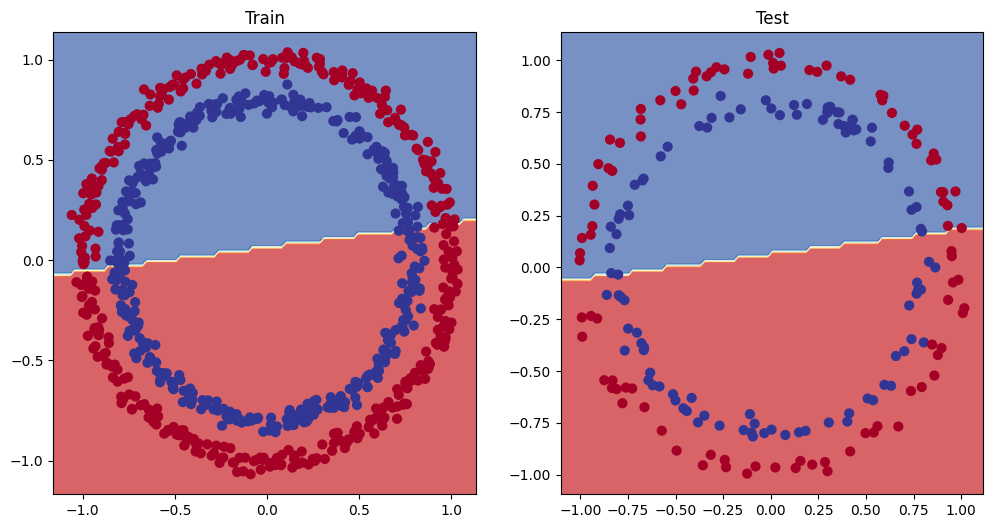

In [91]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [87]:
#Create model that subclasses nn.Module

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    y = self.layer_1(x)
    y = self.relu(y)
    y = self.layer_2(y)
    y = self.layer_3(y)
    return y


In [88]:
model_1 = CircleModelV1().to(device)

In [89]:
from torch.nn.modules.loss import BCELoss
# Setup loss function and optimizer
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss
loss_fn = BCEWithLogitsLoss()
optimizer = SGD(params=model_1.parameters(),
            lr=0.1)

In [90]:
# Train model

epochs = 1000


X_train, y_train =  X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  model_1.train()
  # Forward pass
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_preds=y_preds)
  
  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss Backprop
  loss.backward()

  # Backpropagation
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
     test_logits = model_1(X_test).squeeze()
     test_preds = torch.round(torch.sigmoid(test_logits))

     test_loss = loss_fn(test_logits,
                         y_test)
     test_acc = accuracy_fn(y_true=y_test,
                          y_preds=test_preds)
     if epoch % 10 ==0:
       print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69698, Acc: 50.00% | Test loss: 0.69570, Test acc: 50.00%
Epoch: 10 | Loss: 0.69624, Acc: 49.88% | Test loss: 0.69511, Test acc: 50.00%
Epoch: 20 | Loss: 0.69572, Acc: 44.50% | Test loss: 0.69471, Test acc: 45.50%
Epoch: 30 | Loss: 0.69527, Acc: 41.50% | Test loss: 0.69438, Test acc: 42.50%
Epoch: 40 | Loss: 0.69487, Acc: 40.62% | Test loss: 0.69411, Test acc: 41.00%
Epoch: 50 | Loss: 0.69451, Acc: 39.38% | Test loss: 0.69387, Test acc: 41.00%
Epoch: 60 | Loss: 0.69417, Acc: 39.25% | Test loss: 0.69366, Test acc: 39.50%
Epoch: 70 | Loss: 0.69387, Acc: 39.00% | Test loss: 0.69348, Test acc: 38.00%
Epoch: 80 | Loss: 0.69358, Acc: 39.25% | Test loss: 0.69332, Test acc: 38.00%
Epoch: 90 | Loss: 0.69330, Acc: 40.62% | Test loss: 0.69317, Test acc: 41.50%
Epoch: 100 | Loss: 0.69303, Acc: 45.25% | Test loss: 0.69303, Test acc: 47.50%
Epoch: 110 | Loss: 0.69277, Acc: 47.00% | Test loss: 0.69290, Test acc: 48.00%
Epoch: 120 | Loss: 0.69251, Acc: 48.00% | Test loss: 0.69277, T

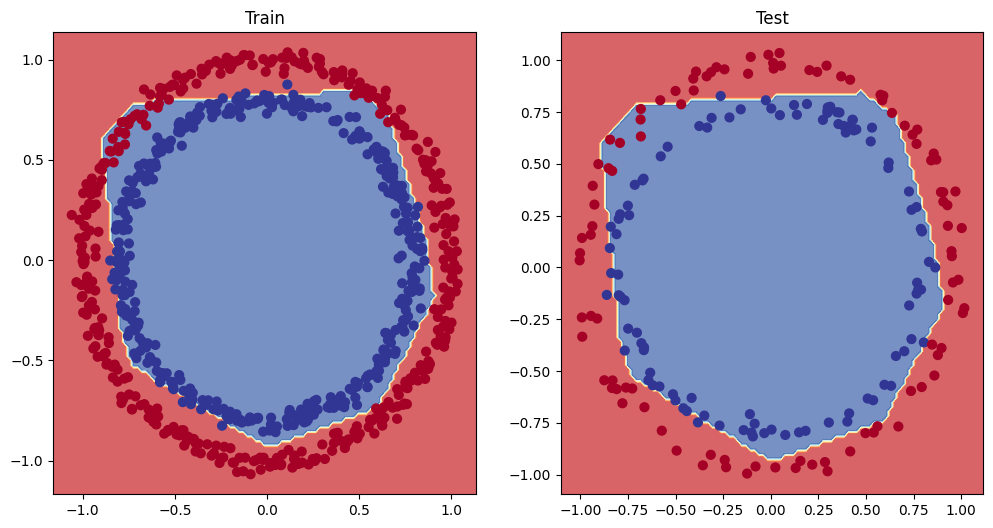

In [92]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)